<a href="https://colab.research.google.com/github/pit85/world-indexes-strategy/blob/master/Strategy_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [395]:
# Zainstalowanie zależności
# !pip install pandas_ta


[*********************100%***********************]  1 of 1 completed
<ipython-input-390-9d17f9738221>:34: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['MA_Signal'][short_window:] = np.where((data['MA50'][short_window:] < data['MA200'][

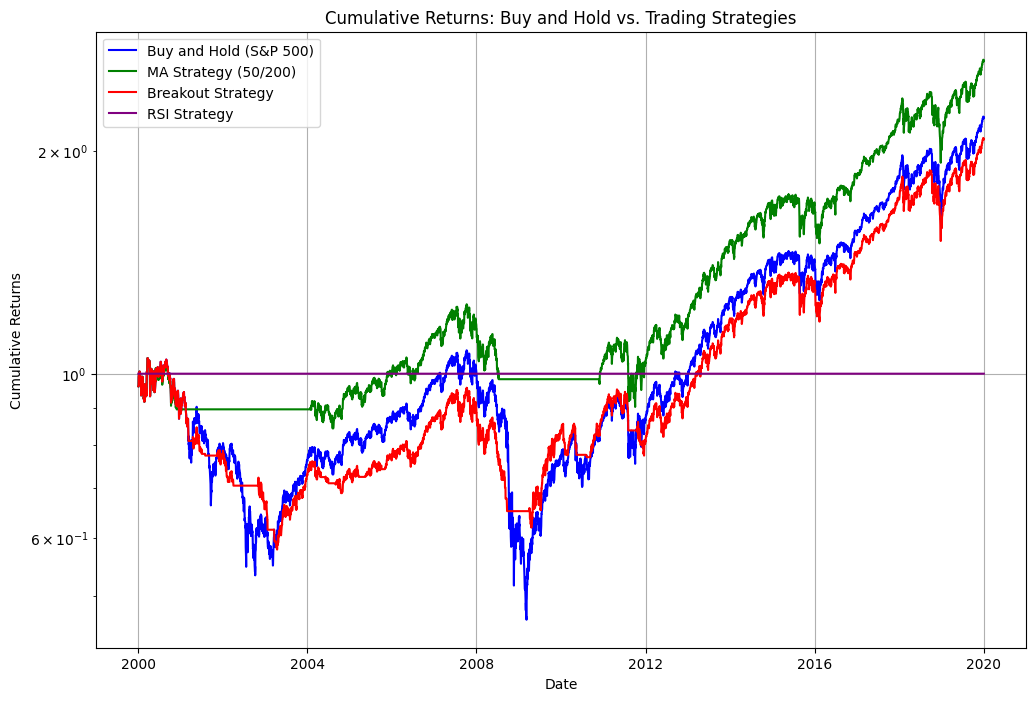

Sharpe Ratio (MA Strategy): 0.37
Sharpe Ratio (Breakout Strategy): 0.26
Sharpe Ratio (RSI Strategy): -173745066793610.91
Sharpe Ratio (Buy and Hold): 0.25
CAGR (Buy and Hold): 4.08%
CAGR (MA Strategy): 5.00%
CAGR (MA Strategy): 3.73%


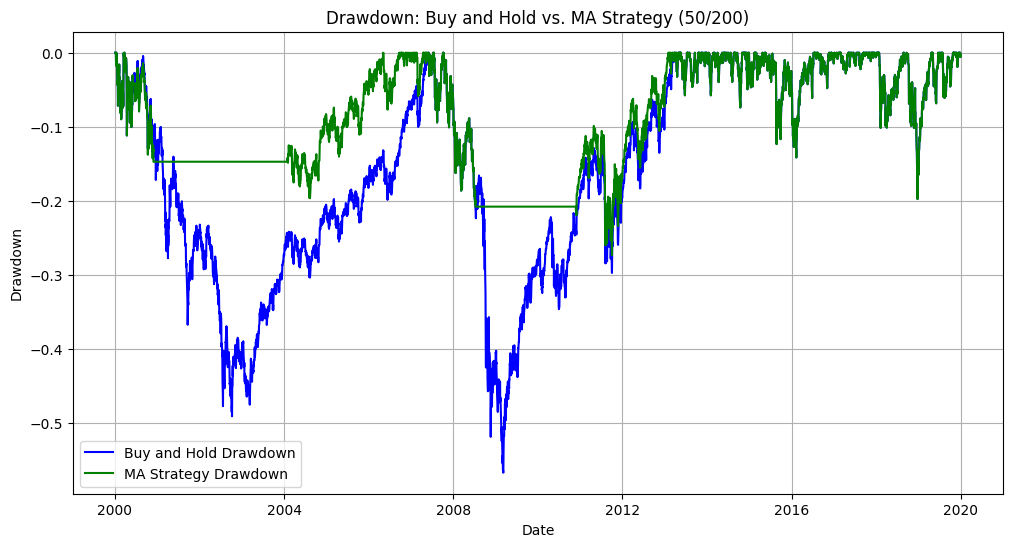

Max Drawdown (Buy and Hold): -56.78%
Max Drawdown (MA Strategy): -27.36%
Max Drawdown (Drawdown Strategy): -44.89%


In [390]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

start_date = "2000-01-01"
end_date = "2020-01-01"

# Download S&P 500 historical data
ticker = '^GSPC'  # S&P 500 index
data = yf.download(ticker, start = start_date, end = end_date)
data['Return'] = data['Adj Close'].pct_change()

# Cumulative Market Return
data['Cumulative_Market_Return'] = (1 + data['Return']).cumprod()

# Function to calculate drawdown
def calculate_drawdown(cumulative_return):
    peak = cumulative_return.cummax()  # Running max to find peak
    drawdown = (cumulative_return - peak) / peak  # Drawdown formula
    max_drawdown = drawdown.min()  # The maximum drawdown (i.e., the largest drawdown)
    return drawdown, max_drawdown


# Calculate drawdown for both strategies
data['Market_Drawdown'], market_max_drawdown = calculate_drawdown(data['Cumulative_Market_Return'])

# Moving Average Crossover Strategy (50/200)
short_window = 100
long_window = 800
data['MA50'] = data['Adj Close'].rolling(window=short_window, min_periods=1).mean()
data['MA200'] = data['Adj Close'].rolling(window=long_window, min_periods=1).mean()
data['MA_Signal'] = 1
data['MA_Signal'][short_window:] = np.where((data['MA50'][short_window:] < data['MA200'][short_window:]) , 0, 1)
data['Signal'] = data['MA_Signal']
data['MA_Strategy_Return'] = data['Return'] * data['MA_Signal'].shift(1)

# Drawdown breakout

data['DD50'] = data['Market_Drawdown'].rolling(window=20, min_periods=1).mean()
data['DD200'] = data['Market_Drawdown'].rolling(window=100, min_periods=1).mean()
data['Breakout_Signal'] = 1
data['Breakout_Signal'][short_window:] = np.where((data['Market_Drawdown'][short_window:] < data['DD200'][short_window:]) & (data['Market_Drawdown'][short_window:]<-0.2), 0, 1)
data['Breakout_Strategy_Return'] = data['Return'] * data['Breakout_Signal'].shift(1)

# RSI Strategy (overbought/oversold)
def calculate_rsi(data, window=14):
    delta = data['Adj Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data)
data['RSI_Signal'] = np.where(data['RSI'] < 30, 1, np.where(data['RSI'] > 70, -1, 0))
data['RSI_Strategy_Return'] = data['Return'] * data['RSI_Signal'].shift(1)

# Cumulative returns for all strategies

data['Cumulative_MA_Return'] = (1 + data['MA_Strategy_Return']).cumprod()
data['Cumulative_Breakout_Return'] = (1 + data['Breakout_Strategy_Return']).cumprod()
data['Cumulative_RSI_Return'] = (1 + data['RSI_Strategy_Return']).cumprod()

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(data.index, data['Cumulative_Market_Return'], label='Buy and Hold (S&P 500)', color='blue')
plt.plot(data.index, data['Cumulative_MA_Return'], label='MA Strategy (50/200)', color='green')
plt.plot(data.index, data['Cumulative_Breakout_Return'], label='Breakout Strategy', color='red')
plt.plot(data.index, data['Cumulative_RSI_Return'], label='RSI Strategy', color='purple')
plt.title('Cumulative Returns: Buy and Hold vs. Trading Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

# Calculate Sharpe Ratios for each strategy
def calculate_sharpe_ratio(returns, risk_free_rate=0.01):
    excess_returns = returns - risk_free_rate / 252
    return np.sqrt(252) * (excess_returns.mean() / excess_returns.std())

ma_sharpe = calculate_sharpe_ratio(data['MA_Strategy_Return'])
breakout_sharpe = calculate_sharpe_ratio(data['Breakout_Strategy_Return'])
rsi_sharpe = calculate_sharpe_ratio(data['RSI_Strategy_Return'])
market_sharpe = calculate_sharpe_ratio(data['Return'])

print(f"Sharpe Ratio (MA Strategy): {ma_sharpe:.2f}")
print(f"Sharpe Ratio (Breakout Strategy): {breakout_sharpe:.2f}")
print(f"Sharpe Ratio (RSI Strategy): {rsi_sharpe:.2f}")
print(f"Sharpe Ratio (Buy and Hold): {market_sharpe:.2f}")

# Function to calculate CAGR
def calculate_cagr(cumulative_return, periods):
    end_value = cumulative_return.iloc[-1]
    years = periods / 252  # Assuming 252 trading days per year
    cagr = (end_value ** (1 / years)) - 1
    return cagr

# Calculate CAGR for both strategies
market_cagr = calculate_cagr(data['Cumulative_Market_Return'], len(data))
strategy_cagr = calculate_cagr(data['Cumulative_MA_Return'], len(data))
strategy_drawdown = calculate_cagr(data['Cumulative_Breakout_Return'], len(data))

# Print CAGR values
print(f"CAGR (Buy and Hold): {market_cagr:.2%}")
print(f"CAGR (MA Strategy): {strategy_cagr:.2%}")
print(f"CAGR (MA Strategy): {strategy_drawdown:.2%}")


# Calculate drawdown for both strategies
data['MA_Drawdown'], strategy_max_drawdown = calculate_drawdown(data['Cumulative_MA_Return'])
data['Drawdown_Drawdown'], drawdown_max_drawdown = calculate_drawdown(data['Cumulative_Breakout_Return'])

# Plot drawdowns
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Market_Drawdown'], label='Buy and Hold Drawdown', color='blue')
plt.plot(data.index, data['MA_Drawdown'], label='MA Strategy Drawdown', color='green')
plt.title('Drawdown: Buy and Hold vs. MA Strategy (50/200)')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

print(f"Max Drawdown (Buy and Hold): {market_max_drawdown:.2%}")
print(f"Max Drawdown (MA Strategy): {strategy_max_drawdown:.2%}")
print(f"Max Drawdown (Drawdown Strategy): {drawdown_max_drawdown:.2%}")

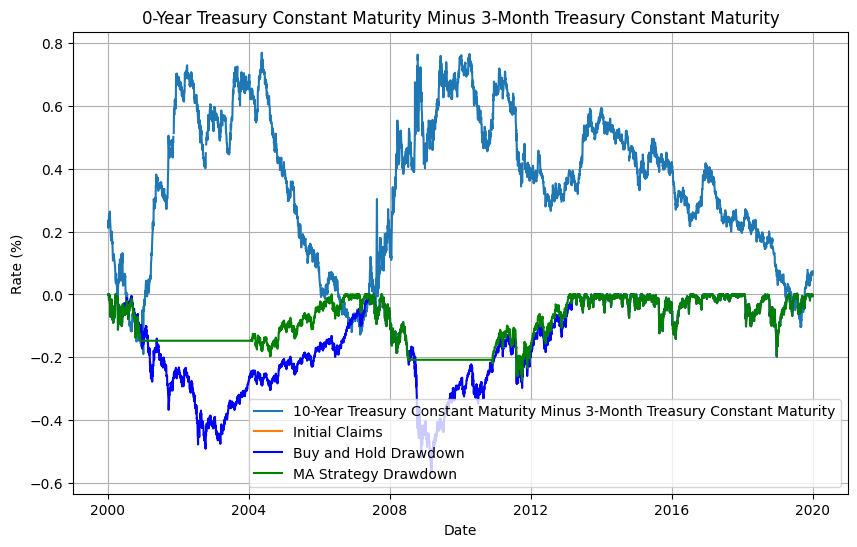

In [391]:

import pandas_datareader.data as datareader
from datetime import date

treasury_spread_code = 'T10Y3M'
initial_claims_code = 'ICSA'
date_source = 'fred'

data['T10Y3M'] = datareader.DataReader(treasury_spread_code, date_source, start_date, end_date)
data['ICSA'] = datareader.DataReader(initial_claims_code, date_source, start_date, end_date)


# Calculate drawdown risk
treashold = 0.1
data['DrawdownOverThreashold'] = np.where(data['Market_Drawdown'] > treashold, 1, 0)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['T10Y3M']/5, label='10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity')
plt.plot(data.index, data['ICSA']/5, label='Initial Claims')
plt.plot(data.index, data['Market_Drawdown'], label='Buy and Hold Drawdown', color='blue')
plt.plot(data.index, data['MA_Drawdown'], label='MA Strategy Drawdown', color='green')

plt.title('0-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.grid(True)
plt.legend()
plt.show()

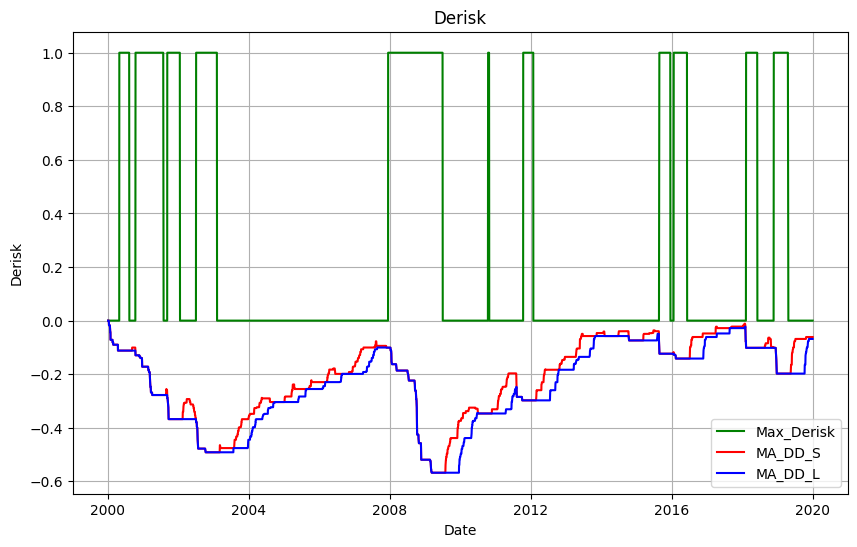

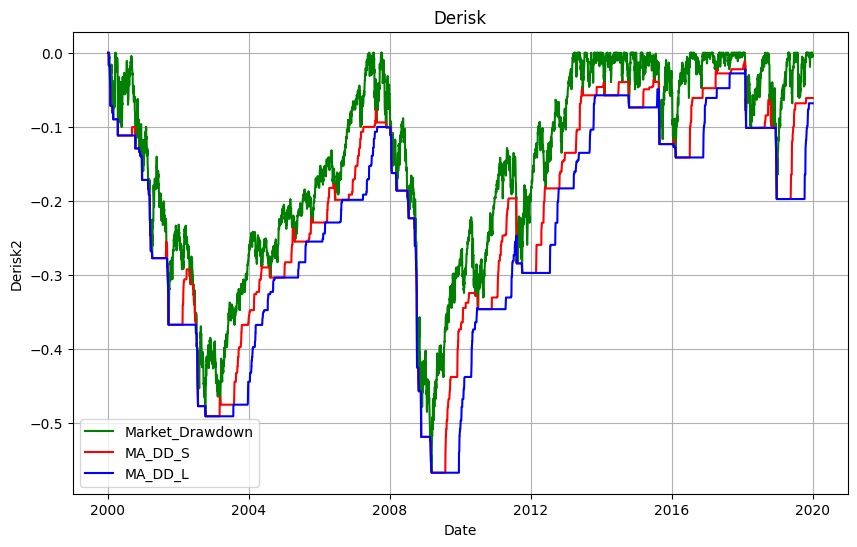

In [392]:
# Derisk
data['Derisk'] = 0
data['Derisk'] =  np.where(data['T10Y3M'] < 0, 1, 0)

data['MA_DD_S'] = data['Market_Drawdown'].rolling(window=100, min_periods=1).min()
data['MA_DD_L'] = data['MA_DD_S'].rolling(window=100, min_periods=1).min()

data['test'] = np.where((data['MA_DD_L'] < -0.90), data['MA_DD_L'].shift(160), data['MA_DD_L'].shift(80))
data['Derisk2'] = np.where((data['MA_DD_L'] < -0.10) & (data['MA_DD_L'] < data['test'] ), 1, 0)

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Derisk2'], label='Max_Derisk', color='green')
plt.plot(data.index, data['MA_DD_S'], label='MA_DD_S', color='red')
plt.plot(data.index, data['MA_DD_L'], label='MA_DD_L', color='blue')
plt.title('Derisk')
plt.xlabel('Date')
plt.ylabel('Derisk')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Market_Drawdown'], label='Market_Drawdown', color='green')
plt.plot(data.index, data['MA_DD_S'], label='MA_DD_S', color='red')
plt.plot(data.index, data['MA_DD_L'], label='MA_DD_L', color='blue')
plt.title('Derisk')
plt.xlabel('Date')
plt.ylabel('Derisk2')
plt.grid(True)
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-393-cc773c549e87>:11: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  sim[0] = initial_value


<Axes: title={'center': 'Growth of $1: UPRO vs UPRO Sim'}, xlabel='Date'>

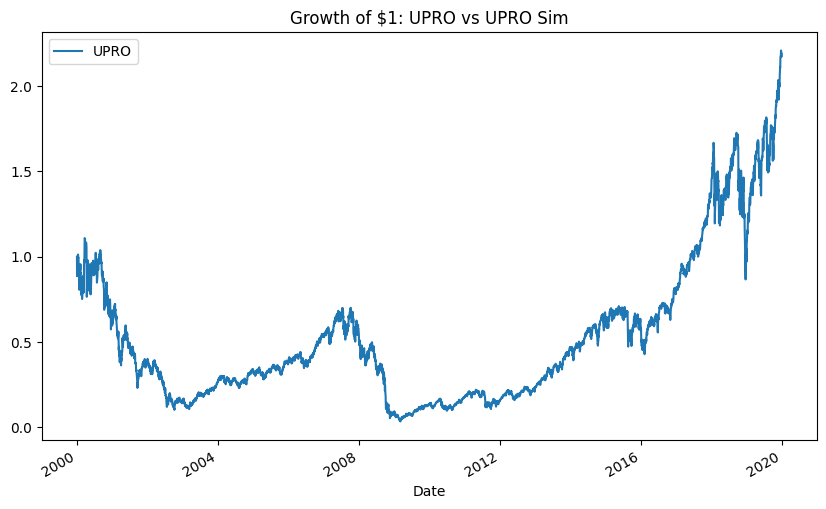

In [393]:
# UPRO Simulation
import datetime

start = datetime.datetime(1980, 1, 1)
end = datetime.datetime(2024, 10, 1)

def sim_leverage(proxy, leverage=1, expense_ratio = 0.0, initial_value=1.0):
    pct_change = proxy.pct_change(1)
    pct_change = (pct_change - expense_ratio / 252) * leverage
    sim = (1 + pct_change).cumprod() * initial_value
    sim[0] = initial_value
    return sim

data['VFINX'] = yf.download("VFINX", start, end)["Adj Close"]
data['UPRO'] = sim_leverage(data['VFINX'], leverage=3.0, expense_ratio=0.0092).rename("UPRO Sim")
data['UPRO'].plot(title="Growth of $1: UPRO vs UPRO Sim", legend=True, figsize=(10,6))

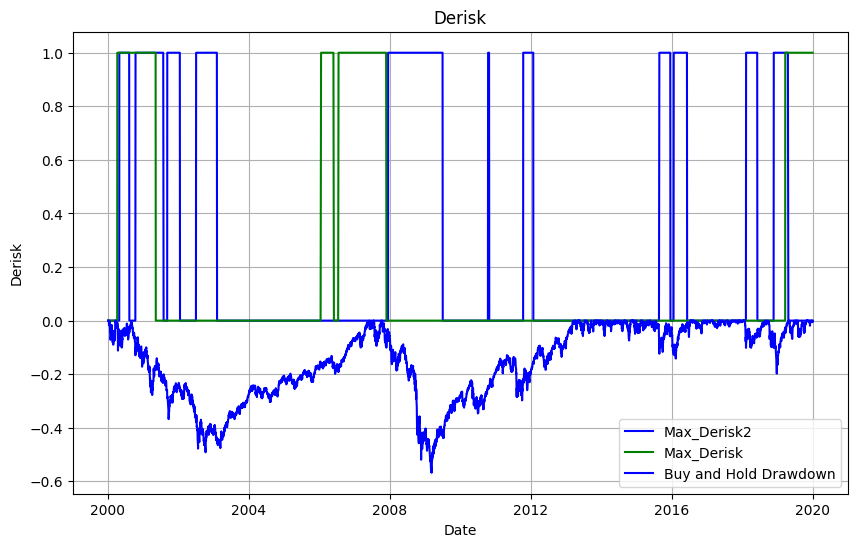

In [394]:
import pandas as pd

def calculate_max_trailing(df, value_column, window_days):
    """
    Calculates the maximum trailing value for the specified column over a rolling window.

    Args:
    df (pd.DataFrame): The input DataFrame containing the value column and a Date index.
    value_column (str): The name of the column for which to calculate the maximum trailing values.
    window_days (int): The number of days to include in the trailing window.

    Returns:
    pd.Series: A pandas Series containing the maximum values over the trailing window for each row.
    """
    # Ensure the DataFrame is sorted by date to apply rolling properly
    df = df.sort_index()

    # Use rolling to calculate the maximum over a specified window of days
    # '1D' frequency allows it to work on daily data
    max_trailing_values = df[value_column].rolling(window=f'{window_days}D', min_periods=1).max()

    return max_trailing_values



# Calculate the maximum trailing value for the 'Value' column over the last 30 days
data['Max_Derisk'] = calculate_max_trailing(data, 'Derisk', 90)
data['Max_Derisk2'] = calculate_max_trailing(data, 'Derisk2', 0)

# Display the DataFrame
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Max_Derisk2'], label='Max_Derisk2', color='blue')
plt.plot(data.index, data['Max_Derisk'], label='Max_Derisk', color='green')
plt.plot(data.index, data['Market_Drawdown'], label='Buy and Hold Drawdown', color='blue')
plt.title('Derisk')
plt.xlabel('Date')
plt.ylabel('Derisk')
plt.grid(True)
plt.legend()
plt.show()



[*********************100%***********************]  1 of 1 completed


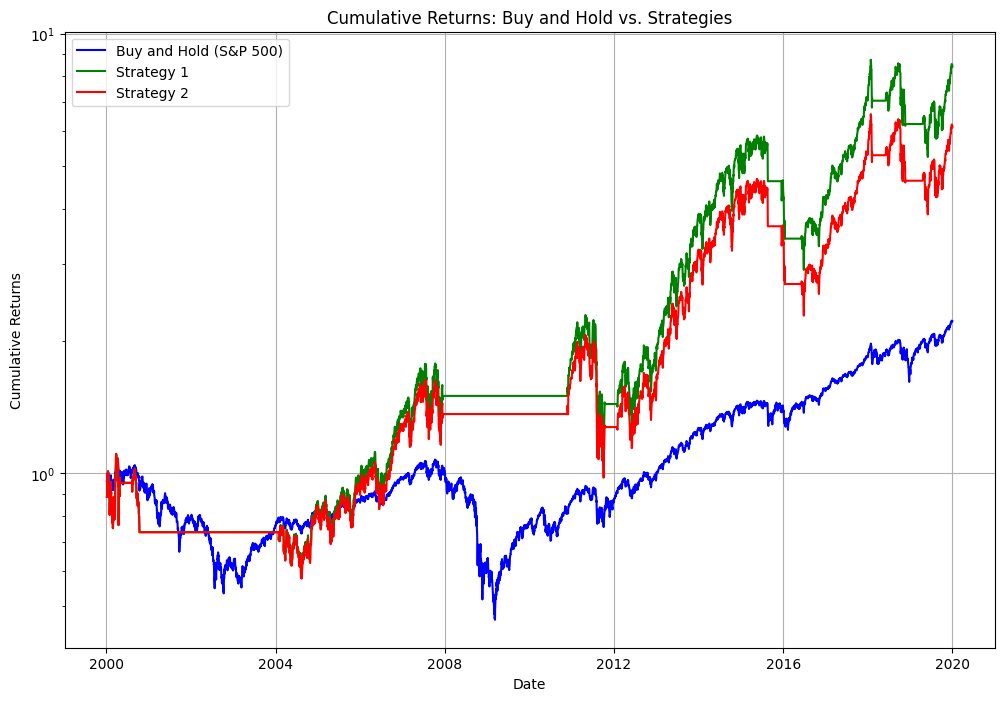

CAGR (Buy and Hold): 4.08%
CAGR (Strategy 1): 11.29%
CAGR (Strategy 2): 9.54%


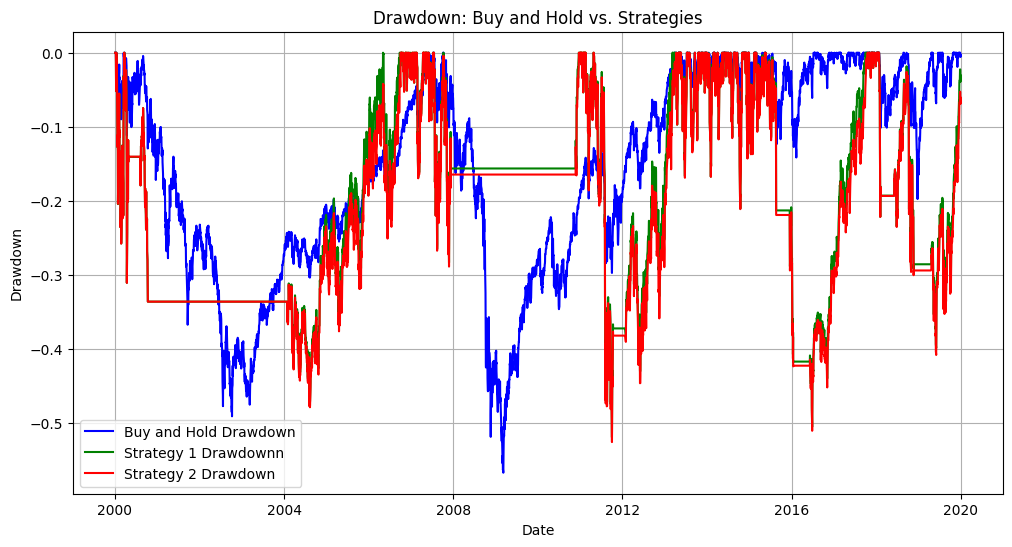

Max Drawdown (Buy and Hold): -56.78%
Max Drawdown (Strategy): -51.99%
Max Drawdown (Strategy 2): -52.63%


In [396]:



# Download S&P 500 historical data from Yahoo Finance
ticker = '^GSPC'  # S&P 500 index
strategy = yf.download(ticker, start=start_date, end=end_date)
strategy['Return'] = strategy['Adj Close'].pct_change()
strategy['Return_Plain_Leverage'] = strategy['Adj Close'].pct_change()*3

strategy['UPRO_Return'] = data['UPRO'].pct_change()
data['Signal2'] = np.where(data['Signal'] == 1, 1, 0)
strategy['Signal'] = np.where(data['Max_Derisk2'] == 0, 1*data['Signal2'], 0)




# Calculate the strategy returns for UPRO
strategy['Strategy_Return'] = strategy['UPRO_Return'] * strategy['Signal']
strategy['Strategy_2_Return'] = strategy['Return_Plain_Leverage']  * strategy['Signal']

# Cumulative returns for both strategiesv - Bug and Hold SPY and MA with UPRO
strategy['Cumulative_Market_Return'] = (1 + strategy['Return']).cumprod()
strategy['Cumulative_Strategy_Return'] = (1 + strategy['Strategy_Return']).cumprod()
strategy['Cumulative_Strategy_2_Return'] = (1 + strategy['Strategy_2_Return']).cumprod()

# Plot the returns comparison
plt.figure(figsize=(12, 8))
plt.plot(strategy.index, strategy['Cumulative_Market_Return'], label='Buy and Hold (S&P 500)', color='blue')
plt.plot(strategy.index, strategy['Cumulative_Strategy_Return'], label='Strategy 1', color='green')
plt.plot(strategy.index, strategy['Cumulative_Strategy_2_Return'], label='Strategy 2', color='red')
plt.title('Cumulative Returns: Buy and Hold vs. Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()


# Calculate CAGR for both strategies
market_cagr = calculate_cagr(strategy['Cumulative_Market_Return'], len(strategy))
strategy_cagr = calculate_cagr(strategy['Cumulative_Strategy_Return'], len(strategy))
strategy_cagr2 = calculate_cagr(strategy['Cumulative_Strategy_2_Return'], len(strategy))

# Print CAGR values
print(f"CAGR (Buy and Hold): {market_cagr:.2%}")
print(f"CAGR (Strategy 1): {strategy_cagr:.2%}")
print(f"CAGR (Strategy 2): {strategy_cagr2:.2%}")

# Calculate drawdown for both strategies
strategy['Market_Drawdown'], market_max_drawdown = calculate_drawdown(strategy['Cumulative_Market_Return'])
strategy['Strategy_Drawdown'], strategy_max_drawdown = calculate_drawdown(strategy['Cumulative_Strategy_Return'])
strategy['Strategy_2_Drawdown'], strategy_max_drawdown2 = calculate_drawdown(strategy['Cumulative_Strategy_2_Return'])

# Plot drawdowns
plt.figure(figsize=(12, 6))
plt.plot(strategy.index, strategy['Market_Drawdown'], label='Buy and Hold Drawdown', color='blue')
plt.plot(strategy.index, strategy['Strategy_Drawdown'], label='Strategy 1 Drawdownn', color='green')
plt.plot(strategy.index, strategy['Strategy_2_Drawdown'], label='Strategy 2 Drawdown', color='red')
plt.title('Drawdown: Buy and Hold vs. Strategies')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

print(f"Max Drawdown (Buy and Hold): {market_max_drawdown:.2%}")
print(f"Max Drawdown (Strategy): {strategy_max_drawdown:.2%}")
print(f"Max Drawdown (Strategy 2): {strategy_max_drawdown2:.2%}")



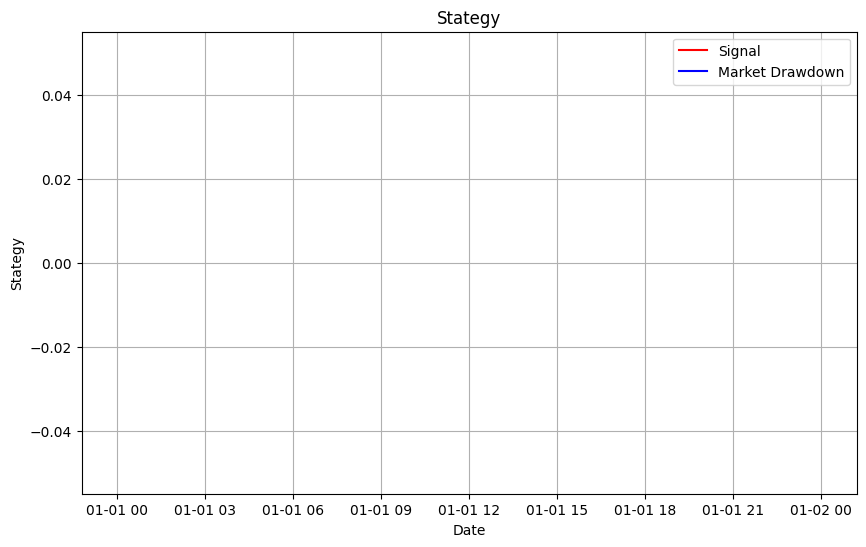

In [397]:
# Define the timeframe (start date and end date)
start_date = '2023-02-01'
end_date = '2024-12-01'

# Filter the DataFrame for the provided timeframe
strategy_filtered = strategy.loc[start_date:end_date]

# Display the DataFrame
plt.figure(figsize=(10, 6))
# Use the index of the filtered DataFrame for plotting
plt.plot(strategy_filtered.index, strategy_filtered['Signal'], label='Signal', color='red')
plt.plot(strategy_filtered.index, strategy_filtered['Market_Drawdown'], label='Market Drawdown', color='blue')
plt.title('Stategy')
plt.xlabel('Date')
plt.ylabel('Stategy')
plt.grid(True)
plt.legend()
plt.show()